# Vehicle Detection

## Imports

In [1]:
import cv2
import glob
from IPython.display import HTML
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import numpy as np
from skimage.feature import hog
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import time

## Color Histogram

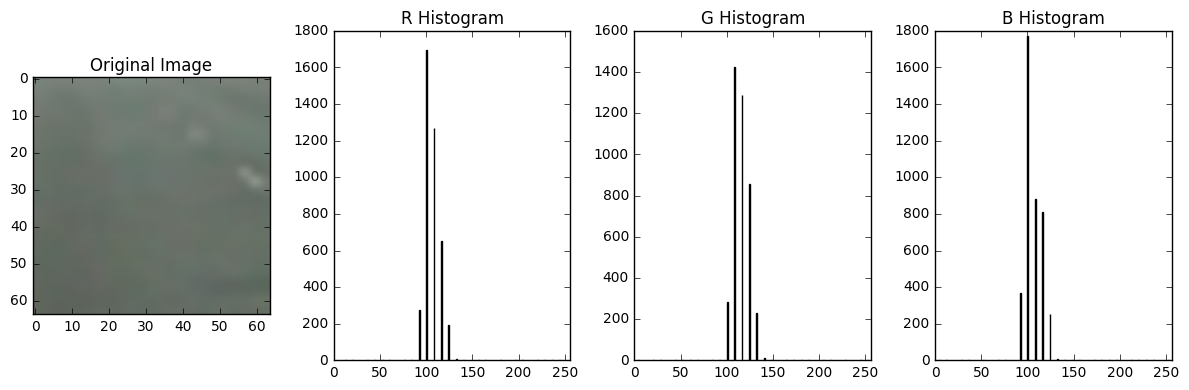

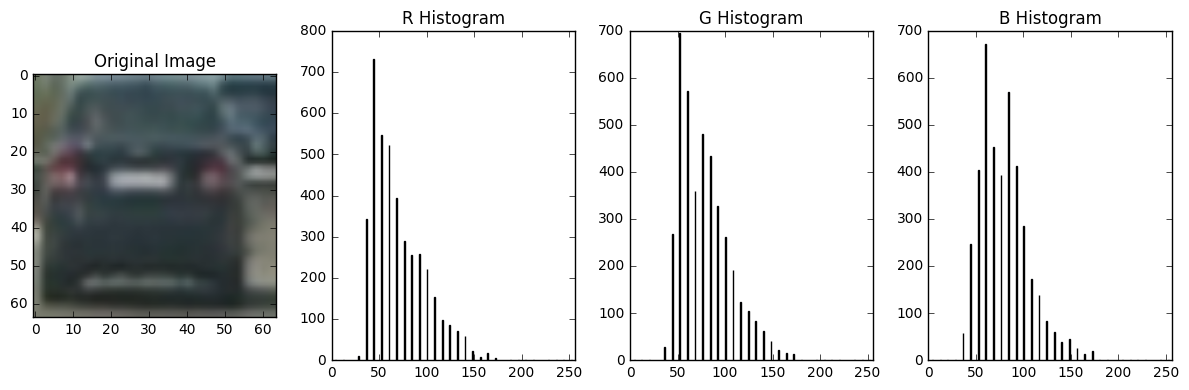

In [2]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)

    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges) - 1]) / 2

    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))

    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

def plot_color_hist(img):
    image = io.imread(img)
    rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

    fig = plt.figure(figsize=(12,4))
    plt.subplot(141)
    plt.title("Original Image")
    plt.imshow(image)
    plt.subplot(142)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title("R Histogram")
    plt.subplot(143)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title("G Histogram")
    plt.subplot(144)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title("B Histogram")
    fig.tight_layout()
    plt.show()

plot_color_hist("non-vehicles/GTI/image1.png")
plot_color_hist("vehicles/GTI_middleclose/image0000.png")

## Bin Spatial

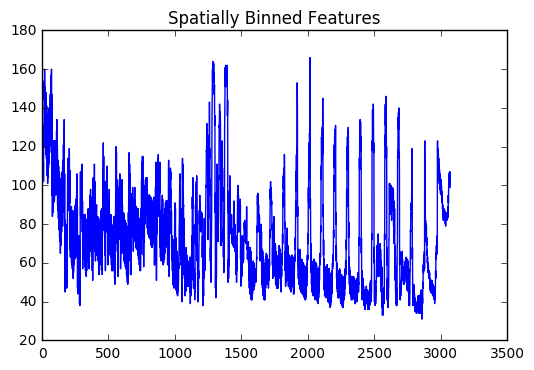

In [3]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

image = io.imread("vehicles/GTI_middleclose/image0000.png")
feature_vec = bin_spatial(image, size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')
plt.show()

## Histogram of Oriented Gradients

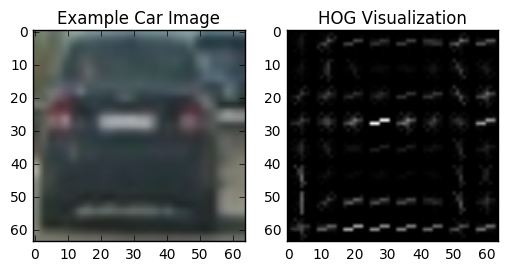

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

image = io.imread("vehicles/GTI_middleclose/image0000.png")
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

## Combine All Features

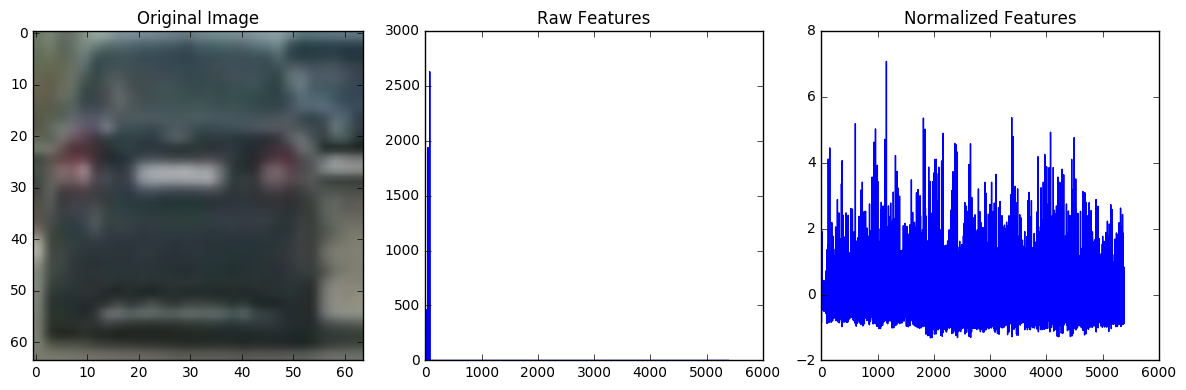

In [32]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        load_images=True, reverse=False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        if load_images:
            image = io.imread(file)
        else:
            image = file
        if reverse:
            image = cv2.flip(image ,1)
        image = cv2.resize(image, (64, 64))
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCRCB':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        _, _, _, _, hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Call get_hog_features() with vis=False, feature_vec=True
        hog_features_0 = get_hog_features(feature_image[:,:,0], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        hog_features_1 = get_hog_features(feature_image[:,:,1], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        hog_features_2 = get_hog_features(feature_image[:,:,2], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate((hist_features, hog_features_0, hog_features_1, hog_features_2)))
    # Return list of feature vectors
    return features

cars = ["vehicles/GTI_middleclose/image0000.png"]
notcars = ["non-vehicles/GTI/image1.png"]

car_features = extract_features(cars, cspace='YCRCB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='YCRCB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(io.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()
plt.show()

## Train A Classifier

In [6]:
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

car_features = extract_features(cars, cspace='YCRCB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
car_features_reverse = extract_features(cars, cspace='YCRCB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), reverse=True)
notcar_features = extract_features(notcars, cspace='YCRCB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features_reverse = extract_features(notcars, cspace='YCRCB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), reverse=True)

# Create an array stack of feature vectors
X = np.vstack((car_features, car_features_reverse, notcar_features, notcar_features_reverse)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features) * 2), np.zeros(len(notcar_features) * 2)))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(t2-t, 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', svc.score(X_train, y_train))
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))
# Check the prediction time for a single sample
t=time.time()
prediction = svc.predict(X_test[0].reshape(1, -1))
t2 = time.time()
print(t2-t, 'Seconds to predict with SVC')

22.387904167175293 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.99187432286
0.0002009868621826172 Seconds to predict with SVC


### Sanity Check Sample Images

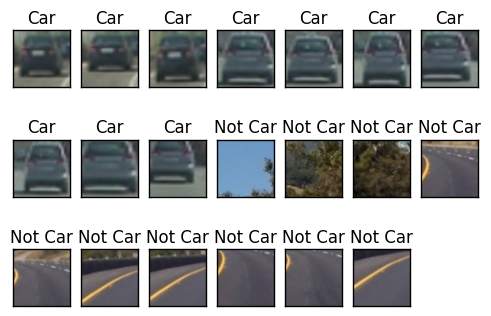

In [31]:
num_to_predict = 20
ncols = 7
nrows = num_to_predict // ncols + 1

cars = cars[:num_to_predict // 2]
notcars = notcars[:num_to_predict // 2]

car_features = extract_features(cars, cspace='YCRCB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='YCRCB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

fig = plt.figure()
for i, x in enumerate(scaled_X):
    prediction = svc.predict(x.reshape(1, -1))
    if i < num_to_predict // 2:
        image = cars[i]
    else:
        image = notcars[i-num_to_predict]
    axis = fig.add_subplot(nrows, ncols, i + 1)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    axis.imshow(io.imread(image))
    axis.set_title("Car" if prediction[0] else "Not Car")
plt.show()

## Sliding Window

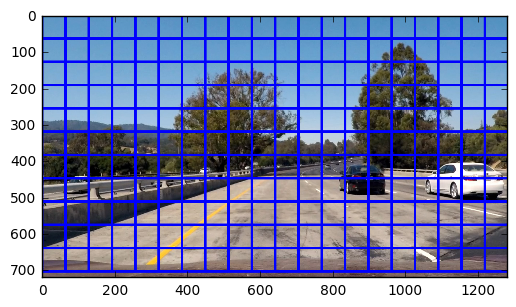

In [8]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

image = io.imread("test_images/test1.jpg")
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()

## Combining Sliding Windows and Classifier

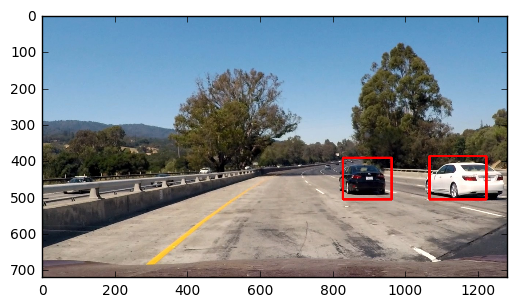

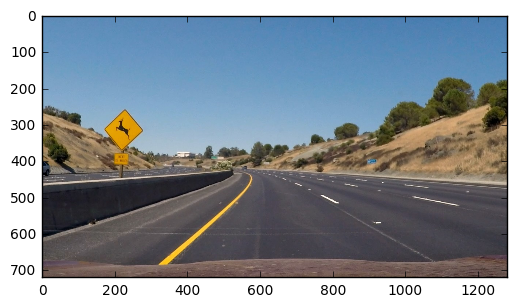

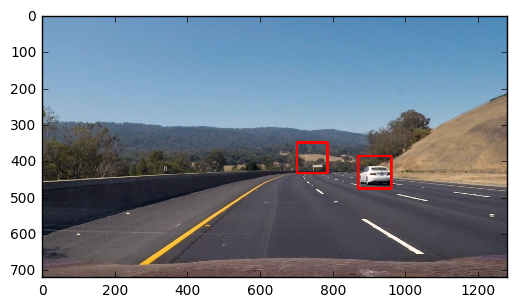

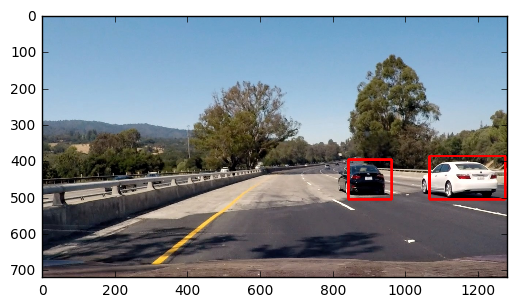

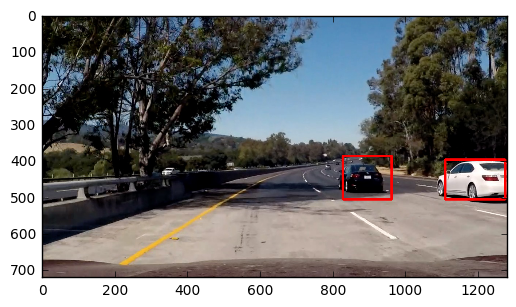

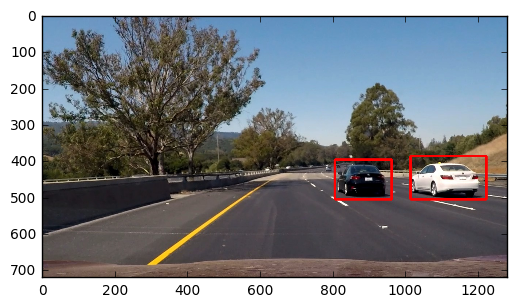

In [28]:
frames_before_seen = 8

class Car:
    def __init__(self, xmin, ymin, xmax, ymax):
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        self.times_seen = 0
        self.seen_in_last_frame = True
        self.frames_since_last_seen = 0
        self.prev_frames = []

    def get_coords(self):
        return ((self.xmin, self.ymin), (self.xmax, self.ymax))

    def adjust_coords(self, new_car):
        if self.times_seen < 8:
            self.prev_frames.append(new_car)
        else:
            self.prev_frames[self.times_seen % 8] = new_car
        self.xmin = sum([prev_frame[0][0] for prev_frame in self.prev_frames]) // len(self.prev_frames)
        self.ymin = sum([prev_frame[0][1] for prev_frame in self.prev_frames]) // len(self.prev_frames)
        self.xmax = sum([prev_frame[1][0] for prev_frame in self.prev_frames]) // len(self.prev_frames)
        self.ymax = sum([prev_frame[1][1] for prev_frame in self.prev_frames]) // len(self.prev_frames)

class Metadata: 
    def __init__(self):
        self.cars = []
        
    def add_car(self, car_coords):
        self.cars.append(Car(car_coords[0][0], car_coords[0][1], car_coords[1][0], car_coords[1][1]))

def overlaps(a, b):
    a_x_min = a[0][0]
    a_x_max = a[1][0]
    a_y_min = a[0][1]
    a_y_max = a[1][1]
    b_x_min = b[0][0]
    b_x_max = b[1][0]
    b_y_min = b[0][1]
    b_y_max = b[1][1]
    # Is a to the left of b?
    if a_x_max < b_x_min:
        return False
    # Is a to the right of b?
    if a_x_min > b_x_max:
        return False
    # Is a above b?
    if a_y_max < b_y_min:
        return False
    # Is a below b?
    if a_y_min > b_y_max:
        return False
    return True

def aggregate_boxes(windows_with_cars):
    aggregate = []
    for window in windows_with_cars:
        seen = False
        for boxes in aggregate:
            for box in boxes:
                if overlaps(window, box):
                    boxes.append(window)
                    seen = True
                    break
        if not seen:
            aggregate.append([window])
    distinct_cars = []
    for car in aggregate:
        x_min = min([x[0][0] for x in car]) #// len(car)
        x_max = max([x[1][0] for x in car]) #// len(car)
        y_min = min([y[0][1] for y in car]) #// len(car)
        y_max = max([y[1][1] for y in car]) #// len(car)
        distinct_cars.append(((x_min, y_min), (x_max, y_max)))
    return distinct_cars

def identify_cars(image):
    starting_size = 64
    image_to_coord = []
    for i in range(1, 5):
        windows = slide_window(image, x_start_stop=[700, 1280], y_start_stop=[350, 650], 
                    xy_window=(starting_size + (i * 10), starting_size + (i * 10)), xy_overlap=(0.5, 0.5))
        for window in windows:
            window_image = image[window[0][1]:window[1][1], window[0][0]:window[1][0]]
            image_to_coord.append((window_image, window))
    X = extract_features([x[0] for x in image_to_coord], cspace='YCRCB', spatial_size=(32, 32),
                         hist_bins=32, hist_range=(0, 256), load_images=False)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    windows_with_cars = []
    for i, x in enumerate(scaled_X):
        prediction = svc.predict(x.reshape(1, -1))
        if prediction[0]:
            windows_with_cars.append(image_to_coord[i][1])
    distinct_cars = aggregate_boxes(windows_with_cars)
    return distinct_cars

def process_image(image):
    cars = identify_cars(image)
    for prev_cars in meta.cars:
        prev_cars.seen_in_last_frame = False
    for i, car in enumerate(cars):
        car_seen = False
        for prev_car in meta.cars:
            if overlaps(car, prev_car.get_coords()):
                prev_car.adjust_coords(car)
                prev_car.times_seen += 1
                prev_car.seen_in_last_frame = True
                prev_car.frames_since_last_seen = 0
                car_seen = True
                break
        if not car_seen:
            meta.add_car(car)
    for prev_car in meta.cars:
        if not prev_car.seen_in_last_frame:
            prev_car.frames_since_last_seen += 1
    meta.cars = [car for car in meta.cars if car.frames_since_last_seen < 10]
    image = draw_boxes(image, [car.get_coords() for car in meta.cars if car.times_seen >= frames_before_seen],
                       color=(255, 0, 0), thick=6)
    return image

test_images = glob.glob('test_images/*.jpg')
for test_image in test_images:
    frames_before_seen = 0
    meta = Metadata()
    image = io.imread(test_image)
    image_with_cars = process_image(image)
    plt.imshow(image_with_cars)
    plt.show()

## Video

In [29]:
meta = Metadata()
frames_before_seen = 8

clip1 = VideoFileClip("project_video.mp4")
lane_clip = clip1.fl_image(process_image)
%time lane_clip.write_videofile("with_cars.mp4", audio=False)

[MoviePy] >>>> Building video with_cars.mp4
[MoviePy] Writing video with_cars.mp4



100%|█████████▉| 1260/1261 [21:05<00:01,  1.08s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: with_cars.mp4 

CPU times: user 20min 56s, sys: 7.59 s, total: 21min 4s
Wall time: 21min 6s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("with_cars.mp4"))